Absorption cross-section: 7.786474865982591e-18


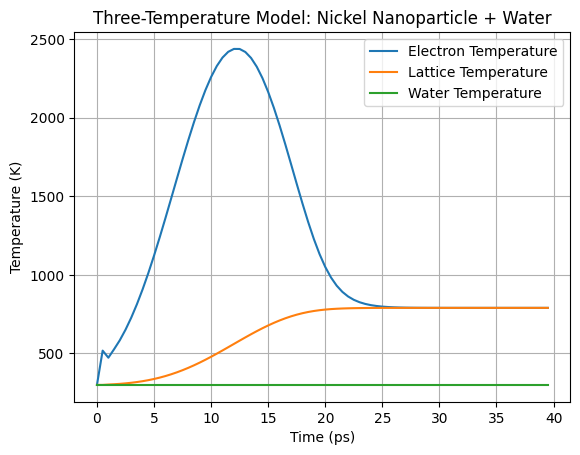

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Constants (SI units)
K_B = 1.380649e-23  # Boltzmann constant, J/K
C_e_coeff = 100  # Rough estimation for the electronic heat capacity coefficient, J/(m^3*K^2) Ce(Te) ? Pas une fonciton de la tempréature ?
C_i = 4.5e6  # Lattice heat capacity, J/(m^3*K)
C_w = 4.184e6  # Heat capacity of water, J/(m^3*K)
gamma = 1e17  # Electron-phonon coupling constant, W/(m^3*K) G(Te) ?
h = 1e5  # Heat transfer coefficient to water, W/(m^2*K)

T_m = 300  # Initial water temperature, K (also initial NP temp)
radius = 5e-9  # Nanoparticle radius, m
area = np.pi * (radius**2)  # Cross-sectional area, m^2
volume = (4/3) * np.pi * (radius**3)  # Nanoparticle volume, m^3
water_volume = (4/3) * np.pi * ((radius * 2)**3) - volume
# Define size of water volume around NanoParticle for modelling heat dissipation.

# Laser parameters
fluence = 300  # J/m^2 (30 mJ/cm^2)
tau = 1e-11  # Pulse duration, s (100 fs)
wavelength = 400e-9  # Laser wavelength, m

# Optical Properties (Nickel) - Change for other materials as needed
n = 2.3  # Refractive index
k = 3.5  # Extinction coefficient

epsilon = (n + 1j * k)**2  # Complex dielectric function
epsilon_m = 1.77  # Water dielectric function

sigma_abs = ((8 * np.pi**2 * radius**3) / wavelength) * np.imag((epsilon - epsilon_m) / (epsilon + 2 * epsilon_m))

print("Absorption cross-section:", sigma_abs)

# Time axis setup
time_step = tau / 20  # Smaller time steps for more accurate results
time = np.arange(0, 40e-12, time_step)  # Time from 0 to 40 ps

# Gaussian laser pulse function (Corrected for peak at t=0)
def gaussian_pulse(t):
    return (fluence / (tau * np.sqrt(np.pi / np.log(2)))) * np.exp((-4 * np.log(2) * (t - tau)**2) / tau**2) # Fixed time component

# Time-dependent laser source term Q (Power density)
intensity = gaussian_pulse(time)

Q = (sigma_abs * intensity) / volume  # Volumetric heat source, W/m^3

# Initialize temperature arrays
Te = np.zeros(len(time))
Ti = np.zeros(len(time))
Tw = np.zeros(len(time))

Te[0] = T_m  # Initial temperatures equal to surrounding water
Ti[0] = T_m
Tw[0] = T_m

#Verlet Algorithm (Explicit):
for i in range(0, len(time) - 1):
    C_e = C_e_coeff * Te[i]  # Update electron heat capacity based on temperature
    dt = time_step

    # Calculate new Te, Ti and Tw
    Te[i + 1] = Te[i] + (dt / C_e) * (-gamma * (Te[i] - Ti[i]) + Q[i] - h * (Te[i] - Tw[i]))
    Ti[i + 1] = Ti[i] + (dt / C_i) * (gamma * (Te[i] - Ti[i]) - h * (Ti[i] - Tw[i]))
    Tw[i + 1] = Tw[i] + (dt / C_w) * (h * (Ti[i] - Tw[i]) * volume / water_volume)

    # Ensure temperatures don't go below 0
    Te[i + 1] = max(Te[i + 1], 0)
    Ti[i + 1] = max(Ti[i + 1], 0)
    Tw[i + 1] = max(Tw[i + 1], 0)

# Plotting the results
plt.plot(time / (1e-12), Te, label="Electron Temperature")
plt.plot(time / (1e-12), Ti, label="Lattice Temperature")
plt.plot(time / (1e-12), Tw, label="Water Temperature")

plt.xlabel("Time (ps)")
plt.ylabel("Temperature (K)")
plt.title("Three-Temperature Model: Nickel Nanoparticle + Water")
plt.legend()
plt.grid(True)
plt.show()

In [2]:
# gen.py
import numpy as np

# Constants (SI units)
K_B = 1.380649e-23  # Boltzmann constant, J/K
C_e_coeff = 100     # J/(m^3*K^2)  -> Ce(Te) = C_e_coeff * Te
C_i = 4.5e6         # Lattice heat capacity, J/(m^3*K)
C_w = 4.184e6       # Heat capacity of water, J/(m^3*K)
gamma = 1e17        # Electron-phonon coupling constant, W/(m^3*K)
h = 1e5             # Heat transfer coefficient to water, W/(m^2*K)

T_m = 300           # Initial temperature, K
radius = 5e-9
area = np.pi * (radius**2)
volume = (4/3) * np.pi * (radius**3)
water_volume = (4/3) * np.pi * ((radius * 2)**3) - volume

def generate_data(
    fluence=300,          # J/m^2  (30 mJ/cm^2)
    tau=1e-11,            # s
    wavelength=400e-9,    # m
    n=2.3,                # refractive index (Nickel, approx)
    k=3.5,                # extinction coefficient
    t_end=40e-12,         # s, simulate up to 40 ps
    steps_per_tau=20      # time resolution: dt = tau / steps_per_tau
):
    # optical props
    epsilon = (n + 1j * k)**2
    epsilon_m = 1.77  # water dielectric
    sigma_abs = ((8 * np.pi**2 * radius**3) / wavelength) * np.imag((epsilon - epsilon_m) / (epsilon + 2 * epsilon_m))

    # time axis
    time_step = tau / steps_per_tau
    time = np.arange(0, t_end, time_step)

    # laser pulse (Gaussian centered around t = tau)
    def gaussian_pulse(t):
        return (fluence / (tau * np.sqrt(np.pi / np.log(2)))) * np.exp((-4 * np.log(2) * (t - tau)**2) / tau**2)

    intensity = gaussian_pulse(time)
    Q = (sigma_abs * intensity) / volume  # W/m^3

    # init temps
    Te = np.zeros(len(time)); Ti = np.zeros(len(time)); Tw = np.zeros(len(time))
    Te[0] = T_m; Ti[0] = T_m; Tw[0] = T_m

    # explicit update
    for i in range(0, len(time) - 1):
        C_e = C_e_coeff * Te[i]
        dt = time_step

        Te[i + 1] = Te[i] + (dt / C_e) * (-gamma * (Te[i] - Ti[i]) + Q[i] - h * (Te[i] - Tw[i]))
        Ti[i + 1] = Ti[i] + (dt / C_i) * (gamma * (Te[i] - Ti[i]) - h * (Ti[i] - Tw[i]))
        Tw[i + 1] = Tw[i] + (dt / C_w) * (h * (Ti[i] - Tw[i]) * volume / water_volume)

        # clamp to non-negative
        Te[i + 1] = max(Te[i + 1], 0.0)
        Ti[i + 1] = max(Ti[i + 1], 0.0)
        Tw[i + 1] = max(Tw[i + 1], 0.0)

    return time, Te, Ti, Tw, sigma_abs


In [3]:
# generer les données d'entrainement et de validation et de test en utilisant la fonction generate_data
time, Te, Ti, Tw, sigma_abs = generate_data()
# diviser les données en ensembles d'entrainement, de validation et de test
train_size = int(0.6 * len(time))
val_size = int(0.2 * len(time))
test_size = len(time) - train_size - val_size
train_time = time[:train_size]
train_Te = Te[:train_size]
train_Ti = Ti[:train_size]
train_Tw = Tw[:train_size]
val_time = time[train_size:train_size + val_size]
val_Te = Te[train_size:train_size + val_size]
val_Ti = Ti[train_size:train_size + val_size]
val_Tw = Tw[train_size:train_size + val_size]
test_time = time[train_size + val_size:]
test_Te = Te[train_size + val_size:]
test_Ti = Ti[train_size + val_size:]
test_Tw = Tw[train_size + val_size:]
# sauvegarder les données dans des fichiers numpy
np.savez('train_data.npz', time=train_time, Te=train_Te, Ti=train_Ti, Tw=train_Tw)
np.savez('val_data.npz', time=val_time, Te=val_Te, Ti=val_Ti, Tw=val_Tw)
np.savez('test_data.npz', time=test_time, Te=test_Te, Ti=test_Ti, Tw=test_Tw)


In [4]:
# modèle de réseau de neurones pour prédire les températures Te, Ti, Tw à partir du temps
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Charger les données d'entrainement
train_data = np.load('train_data.npz')
train_time = train_data['time']
train_Te = train_data['Te']
train_Ti = train_data['Ti']
train_Tw = train_data['Tw']
# Préparer les données d'entrainement
train_time = train_time.reshape(-1, 1)
train_targets = np.vstack((train_Te, train_Ti, train_Tw)).T
# Définir le modèle de réseau de neurones
model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3)  # Trois sorties pour Te, Ti, Tw
])
model.compile(optimizer='adam', loss='mse')
# Entraîner le modèle
model.fit(train_time, train_targets, epochs=50, batch_size=32, validation_split=0.2)
# Sauvegarder le modèle entrainé
model.save('three_temp_model.h5')




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "e:\Logiciel\python312\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "e:\Logiciel\python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "e:\Logiciel\python312\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "e:\Logiciel\python312\Lib\site-packages\tornado

AttributeError: _ARRAY_API not found

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 1125855.3750 - val_loss: 545537.3750
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1125843.7500 - val_loss: 545527.3750
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1125830.5000 - val_loss: 545516.8125
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1125816.0000 - val_loss: 545505.5000
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 1125800.7500 - val_loss: 545493.5625
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1125784.8750 - val_loss: 545480.6250
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1125767.3750 - val_loss: 545466.8125
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1125748.5000 - val_loss: 545451.8750
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1125728.8750 - val_loss: 545435.9375
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1125707.7500 - val_loss: 545419.0000
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 

In [5]:
# tester le modèle de réseau de neurones sur les données de test
test_data = np.load('test_data.npz')
test_time = test_data['time']
test_Te = test_data['Te']
test_Ti = test_data['Ti']
test_Tw = test_data['Tw']
test_time = test_time.reshape(-1, 1)
test_targets = np.vstack((test_Te, test_Ti, test_Tw)).T
# Charger le modèle entrainé
model = keras.models.load_model('three_temp_model.h5')
# Faire des prédictions
predictions = model.predict(test_time)
# Calculer l'erreur moyenne quadratique
mse = np.mean((predictions - test_targets)**2)
print("Mean Squared Error on test data:", mse)

ValueError: Could not deserialize 'keras.metrics.mse' because it is not a KerasSaveable subclass